In [341]:
# Laura Guo
# 22 June 2020
# This program generates a 1D maze with three signals and trains two neural network models (one for agent movement and one for input gate decisions) to solve the maze.

import random
import hrr
import keras
import numpy as np
import matplotlib.pyplot as plt

# ENVIRONMENT INITIALIZATION
# signals
signals = ['red', 'green', 'yellow']
off_signal = 'empty'

# maze
maze_len = 10
maze = [''] * maze_len # visual representation of where the agent and reward are

# rewards/goals
reward = [None] * len(signals) # contains the amount of reward for each state and for each signal
goal_state = [-1] * len(signals) # contains the index of the goal state for each signal
goal_reward_amount = 0 # amount of reward given at the goal state

for i in range(len(signals)): # generating the contents of the above variables
	reward[i] = [-1] * maze_len 
	goal_state[i] = random.randint(0, maze_len - 1) 
	reward[i][goal_state[i]] = goal_reward_amount

# training episodes/variables
epochs = 1
episodes = 4000

gamma = 1 # used in the value function
epsilon = 0.03 # determines number of exploratory moves
epsilon_decay_factor = 0.999 # determines how quickly the epsilon decays
epsilon_min = 0 # the minimum epsilon; epsilon will stop decaying when reaching this point
p_lambda = 0.1 # used for eligibility

# current environment factors
current_signal = off_signal # contains the current signal that the agent is seeing
current_maze = -1 # contains the index of the current signal/maze the agent is working on

# AGENT INITIALIZATION (includes LTM and neural network models)
wm = off_signal

hrr_len = 2048
ltm = hrr.LTM(N = hrr_len)
lr = 0.1

# agent movement model
move_model = keras.Sequential()
move_model.add(keras.layers.Dense(1, activation = "linear", input_shape = [hrr_len], use_bias = False))
#move_model.add(keras.layers.Dense(256, activation = "linear", input_shape = [hrr_len], use_bias = False))
#move_model.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
move_model.compile(loss = keras.losses.mse, optimizer = keras.optimizers.SGD(lr = lr))

# input gate model
input_gate_model = keras.Sequential()
input_gate_model.add(keras.layers.Dense(1, activation = "linear", input_shape = [hrr_len], use_bias = False))
#input_gate_model.add(keras.layers.Dense(64, activation = "linear", input_shape = [hrr_len], use_bias = False))
#input_gate_model.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
input_gate_model.compile(loss = keras.losses.mse, optimizer = keras.optimizers.SGD(lr = lr))

models = [move_model, input_gate_model]

# PERFORMANCE MEASUREMENTS
num_items_per_avg = episodes / 100 # number of items to average together
suboptimal_steps = [None] * episodes # contains the number of suboptimal steps for each episode
suboptimal_steps_avg = [None] * int(episodes / num_items_per_avg) # contains an average of suboptimal steps for the specified number of episodes

# FUNCTIONS
# policy function for moving to the next state - agent determines if it will move left or right given the current agent location; returns the new state to move to
def move_policy(s):
	right_state = right(s)
	left_state = left(s)
	
	left_state_value = move_model.predict(left_state)
	right_state_value = move_model.predict(right_state)
	
	if random.random() < epsilon: # determines if this move should be an exploratory move
		left_state_value = right_state_value # set the values to be equal so that a random move is chosen

	if right_state_value > left_state_value:
		new_state = right_state
	elif right_state_value < left_state_value:
		new_state = left_state
	else:
		new_state = left_state if random.random() < 0.5 else right_state
			
	return decode_index(new_state)

# policy function for the input gate - agent determines if it will open or close the input gate; returns true to open input gate
def open_input_policy(s):
	open_value = input_gate_model.predict(encode(s, off_signal, current_signal))
	close_value = input_gate_model.predict(encode(s, off_signal, wm))
	
	if random.random() < epsilon: # determines if this move should be an exploratory move
		open_value = close_value # set the values to be equal so that a random move is chosen
	
	if open_value > close_value:
		return True
	elif close_value > open_value:
		return False
	else:
		return True if random.random() < 0.5 else False

# returns the HRR for the state to the right of the given position
def right(s):
	if s != (maze_len - 1):
		return encode_index(s + 1)
	else:
		return encode_index(0)
	
# returns the HRR for the state to the left of the given position
def left(s):
	if s != 0:
		return encode_index(s - 1)
	else:
		return encode_index(maze_len - 1)

# returns a specific state based on the given HRR
def decode_index(hrr):
	str = ltm.decode(hrr)
	str_parts = str.split('*')
	
	for item in str_parts: 
		if item[0] == 's': # if the first letter of the section of the decoded HRR is an 's', then it is possible that the rest of the section contains the state.
			rest_of_str = item[1 : len(item)]
			
			if rest_of_str.isdigit(): # if the rest of the HRR part is a number\
				return int(rest_of_str) # then the state has been found

# encodes the given index, signal, and working memory contents; returns the resulting HRR
def encode(i, signal, wm):
	return ltm.encode('s%s*%s*wm_%s' % (i, signal, wm))

# encodes the given index, the current signal, and the current working memory into LTM; returns the resulting HRR
def encode_index(i):
	return encode(i, current_signal, wm)
	
# returns the given number modified with the logmod function
def logmod(num):
	return np.sign(num) * np.log(np.abs(num) + 1.0)
	
# decreases the epsilon
def epsilon_decay():
	global epsilon
	if epsilon > epsilon_min:
		epsilon = epsilon * epsilon_decay_factor
	
	if epsilon < 0.000001:
		epsilon = epsilon_min

# returns the delta value given the current maze's index and the HRRs of the current and previous HRRs
def delta(maze_index, current_hrr, previous_hrr, model):
	return (reward[maze_index][decode_index(previous_hrr)] + gamma * model.predict(current_hrr)) - model.predict(previous_hrr)

# returns the delta value for the goal scenario given the current maze index and the agent's current HRR
def delta_goal(maze_index, current_hrr, model):
	return reward[maze_index][decode_index(current_hrr)] - model.predict(current_hrr)

# returns the number of steps an optimal solution would use, based on the agent starting point and the reward index
def optimal_steps(agent, goal):
	if agent > goal: # agent is to the right of the goal
		right_steps = maze_len - agent + goal # number of steps to reach goal index if the agent only goes right 
		left_steps = abs(agent - goal) # number of steps to reach goal index if the agent only goes left 
	
	if agent < goal: # agent is to the left of the goal
		right_steps = abs(agent - goal)
		left_steps = maze_len - goal + agent
	
	elif agent == goal: 
		return 0

	return min(right_steps, left_steps)
	
# returns the neural network's current value predictions for each state given a certain signal
def current_predictions(signal):
	return move_model.predict(np.vstack([encode(i, off_signal, signal) for i in range(maze_len)]))

In [344]:
# TRAINING NEURAL NETWORKS
for episode in range(episodes):
	# initializing environment
	current_maze = random.randint(0, len(signals) - 1) # determining which maze will make up the environment for the current episode
	current_goal = goal_state[current_maze]
	current_signal = signals[current_maze] # current signal; on for the very beginning of the episode
	
	# initializing agent
	agent_state = current_goal
	while agent_state == current_goal:
		agent_state = random.randint(0, maze_len - 1) # placing the agent at a random location (that is not the goal state) for the next episode
	
	wm = off_signal
	
	# initializing training, performance measurement, and visualization tools
	num_optimal_steps = optimal_steps(agent_state, current_goal) # determining the optimal number of steps
	num_steps = 0 # current number of steps the agent has taken in this episode
	eligibility = np.zeros((1, hrr_len))
	maze[current_goal] = 'G'
	
	# running episodes
	#print('Episode', episode, '\tSignal:', current_signal)
	print('\rEpisode:', episode, end = '      ')
	while agent_state != current_goal:
	    # input gate decision 
		open_input = open_input_policy(agent_state)
		
		if open_input:
			wm = current_signal
		
		# displaying information about the current maze
		maze[agent_state] = 'A'
		#print('Maze\t\t',  maze, '\tWM contents:', wm, '\tInput Gate Opened:', open_input)
		maze[agent_state] = ''
		
		# making a move
		previous_state = agent_state
		previous_hrr = encode_index(previous_state)
		agent_state = move_policy(agent_state)
		num_steps += 1
		
		# turn off the signal
		current_signal = off_signal 
		
		# training neural network
		eligibility = (p_lambda * eligibility) + previous_hrr
		current_hrr = encode_index(agent_state)
		
		for model in models:
			target = logmod(delta(current_maze, current_hrr, previous_hrr, model)) + model.predict(previous_hrr)
			model.fit(np.array(eligibility), target, epochs = epochs, verbose = 0)

	# training neural network after agent reaches the goal state
	eligibility = (p_lambda * eligibility) + encode_index(agent_state)
	
	for model in models:
		target = logmod(delta_goal(current_maze, current_hrr, model)) + model.predict(current_hrr)
		model.fit(np.array(eligibility), target, epochs = epochs, verbose = 0)
	
	# determining suboptimal steps for the current episode
	suboptimal_steps[episode] = num_steps - num_optimal_steps

	# resetting the goal in preparation for the next episode
	maze[goal_state[current_maze]] = ''
	
	# decreasing epsilon
	epsilon_decay()

Episode: 3999      

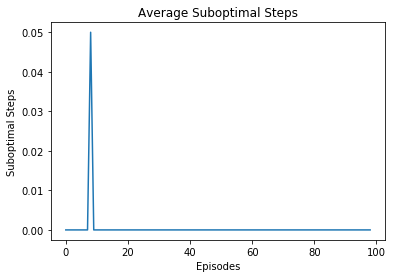

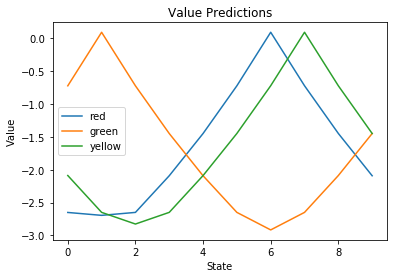

In [345]:
# PERFORMANCE VISUALIZATIONS
# calculating average suboptimal steps 
sum_suboptimal = 0
suboptimal_steps_avg_index = 0

for i in range(len(suboptimal_steps)):
	sum_suboptimal += suboptimal_steps[i]
		
	if i % num_items_per_avg == 0 and i != 0:
		suboptimal_steps_avg[suboptimal_steps_avg_index] = sum_suboptimal / num_items_per_avg
		sum_suboptimal = 0
		suboptimal_steps_avg_index += 1

# graph of the average suboptimal steps 
plt.plot(suboptimal_steps_avg)
plt.title('Average Suboptimal Steps')
plt.xlabel('Episodes')
plt.ylabel('Suboptimal Steps')
plt.show()

# graph of value functions for each signal
data = np.empty((len(signals), maze_len))
for i in range(len(signals)):
	data[i] = current_predictions(signals[i]).T
plt.plot(data.T)
plt.title('Value Predictions')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(signals)
plt.show()

In [278]:
move_model.summary()
input_gate_model.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 1)                 2048      
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 1)                 2048      
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [295]:
goal_state

[8, 3, 0]